In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pickle

In [15]:
def hourPreProcessing(df, columnName):
    for i in range(len(df)):
        oldValue = df.loc[i, columnName]
        if ':' in oldValue:
            hour,minute = oldValue.split(':')
            hour=float(hour)*60
            minute = float(minute)
            newValue = hour+minute
            newValue /=60
        else:
            newValue = float(oldValue)
        df.loc[i, columnName] = newValue


In [16]:
def columnDropper(df, columnName):
    df.drop(columnName, axis=1, inplace=True)


In [17]:
def ColumnSeparator(df, columnName):
    for i in range(len(df)):
        value = df.loc[i, columnName]
        items = value.split(', ')
        for item in items:
            key, val = item.split(': ')
            key=key.strip("{'")
            val=val.strip("'}")
            df.loc[i, key] = val
    df.drop(columns=[columnName], inplace=True)

In [18]:
def NumPreprocessing(data, df):
    # Create a HealthyLifestyleScore and drop original components
    df = df.copy()
    df['HealthyLifestyleScore'] = (
        df['DietQuality'] + df['SleepQuality'] + pd.to_numeric(df['WeeklyPhysicalActivity (hr)'])
    ) / 3
    df.drop(['WeeklyPhysicalActivity (hr)', 'DietQuality', 'SleepQuality'], axis=1, inplace=True)

    # Scale numeric data
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Save the scaler for future use
    with open('scaler.pk1', 'wb') as f:
        pickle.dump(scaler, f)

    # Compute correlation with UPDRS
    corr = df_scaled.corrwith(data['UPDRS']).abs().sort_values(ascending=False)

    # Get top 10 features
    top_features = corr.head(10).index.tolist()
    # print("Top 10 numerical features correlated with UPDRS:", top_features)

    # Select only those features for return
    top_ten_df = df_scaled[top_features]

    return top_ten_df



In [19]:

def encodingCategorical(data, df):
    label_encoders = {}

    # Ensure df is a copy to avoid SettingWithCopyWarning
    df = df.copy()

    for column in df.columns:
        le = LabelEncoder()

        # Add 'Others' category to the unique values from training data
        all_values = list(df[column].unique()) + ['Z']


        # print(list(df['Depression'].unique()))
        # Fit the encoder once with known values
        le.fit(all_values)

        # Apply encoding on the actual column from the original dataset
        df.loc[:, column] = le.transform(data[column])

        # Save the encoder for future use (e.g., test time)
        label_encoders[column] = le

    # Save all encoders to a file
    with open('label_encoders.pkl', 'wb') as f:
        pickle.dump(label_encoders, f)

    return df



In [20]:
def CategoricalPreprocessing(data, df):
    results = []
    
    for feature in df.columns:
        category_counts = df[feature].value_counts()
        valid_categories = category_counts[category_counts > 1].index
        df = data[data[feature].isin(valid_categories)]
        groups = [df[df[feature] == category]['UPDRS'] for category in df[feature].unique()]
        
        if len(groups) > 1:
            f_statistic, p_value = stats.f_oneway(*groups)
            results.append({
                'feature': feature,
                'f_statistic': f_statistic,
                'p_value': p_value
            })

    df = pd.DataFrame(results)
    top_10 = df.sort_values(by='p_value', ascending=True).head(10)
    selected_features = top_10['feature'].tolist()
    selected_df = data[selected_features]
    
    train_mode = selected_df.mode()
    with open('mode.pk1', 'wb') as f:
        pickle.dump(train_mode, f)

    encoded_df = encodingCategorical(data, selected_df)

    encoded_df['Disease Symptoms'] =  (encoded_df['Tremor'] + encoded_df['Bradykinesia'] + encoded_df['SleepDisorders'] + encoded_df['PosturalInstability']) / 4
    encoded_df['ChronicDiseasesScore'] = (encoded_df['Hypertension'] + encoded_df['Diabetes']) / 2
    #
    encoded_df.drop(['Tremor', 'Bradykinesia','SleepDisorders', 'PosturalInstability','Hypertension', 'Diabetes'], axis=1, inplace=True)
    return encoded_df


In [21]:
def PreProcessing():
    data= pd.read_csv("parkinsons_disease_data_reg.csv")
    
    # print(data.head())
    # print(data.describe())
    # print(data.shape)
    # print(data.isnull().sum())

    mode = data['EducationLevel'].mode()[0]
    data['EducationLevel'] = data['EducationLevel'].fillna(mode)
    # print("Duplicated values:")
    # print(data.duplicated().sum())

    hourPreProcessing(data, 'WeeklyPhysicalActivity (hr)')
    columnDropper(data, 'PatientID')
    columnDropper(data, 'DoctorInCharge')
    NumData = data.drop( columns=['Gender','Smoking','EducationLevel','Ethnicity','Symptoms','MedicalHistory'])
    finalNumDF=NumPreprocessing(data,NumData)
    ColumnSeparator(data,'MedicalHistory')
    ColumnSeparator(data,'Symptoms')
    categorical_columns = ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking',
                       'FamilyHistoryParkinsons', 'TraumaticBrainInjury', 'Hypertension',
                       'Diabetes', 'Depression', 'Stroke', 'Tremor', 'Rigidity',
                       'Bradykinesia', 'PosturalInstability', 'SpeechProblems',
                       'SleepDisorders', 'Constipation']
    category_Data = data[categorical_columns]
    # print(category_Data.columns)
    # print(NumData.columns)
    encoded_category_data = CategoricalPreprocessing(data, category_Data)
    data=pd.concat([finalNumDF,encoded_category_data],axis=1)
    # print(data.columns)
    return data
    

In [22]:
def NormalModel(data):
    # Separate target and features
    y = data['UPDRS']
    X = data.drop('UPDRS', axis=1)

    # Define models; Ridge wrapped in pipeline with preprocessor
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso Regression": Pipeline([
            ('regressor', Lasso(alpha=0.01))
        ]),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Ridge alpha=100": Pipeline([
            ('regressor', Ridge(alpha=100))
        ])
    }

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    # Train/test split for calculating train/test scores
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    print(f"Training set size: {len(x_train)}")
    print(f"Test set size: {len(x_test)}")

    for name, model in models.items():
        print(f"Evaluating {name} ...")

        # Cross-validation R² and MSE
        mse_scores = cross_val_score(model, X, y,
                                     scoring=make_scorer(mean_squared_error, greater_is_better=False),
                                     cv=kfold)
        r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kfold)
        avg_mse = -np.mean(mse_scores)
        avg_r2 = np.mean(r2_scores)

        # Train model on train set
        model.fit(x_train, y_train)

        # Predict and score on train and test sets
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print(f" Train R²: {train_r2:.4f}")
        print(f" Test R²: {test_r2:.4f}")
        print(f" CV Mean R²: {avg_r2:.4f}")
        print(f" CV Avg MSE: {avg_mse:.4f}\n")

        results.append({
            "Model": name,
            "Avg MSE": avg_mse,
            "Avg R²": avg_r2,
            "Train R²": train_r2,
            "Test R²": test_r2
        })

    results_df = pd.DataFrame(results).sort_values(by="Avg R²", ascending=False)
    print("Summary of all models:")
    print(results_df)

    return results_df


In [23]:
def PolynomialModel(data):
    y = data['UPDRS']
    X = data.drop('UPDRS', axis=1)

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
        
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    
    models = {
        "Linear Regression (poly)": LinearRegression(),
        "Ridge Regression (poly)": Ridge(alpha=1.0),
        "Lasso Regression (poly)": Lasso(alpha=0.1, max_iter=10000),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=4, random_state=42)
    }
    
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)
    
    
    results = []
    
    for name, model in models.items():
        mse_scores = cross_val_score(model, X_poly, y, scoring=mse_scorer, cv=kfold)
        r2_scores = cross_val_score(model, X_poly, y, scoring=r2_scorer, cv=kfold)
    
        avg_mse = -np.mean(mse_scores)
        avg_r2 = np.mean(r2_scores)
    
        results.append({
            "Model": name,
            "Avg MSE": avg_mse,
            "Avg R²": avg_r2
        })
    
    
    results_df = pd.DataFrame(results).sort_values(by="Avg R²", ascending=False)
    print("\n Boosted Model Results with Feature Extraction:")
    print(results_df)
    
    plt.figure(figsize=(10, 6))
    plt.barh(results_df['Model'], results_df['Avg R²'], color='lightseagreen')
    plt.xlabel("Average R² Score")
    plt.title("Comparison of Regression Models (Boosted with Feature Selection)")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()

In [24]:
data=PreProcessing()
print(data.head(10))


      UPDRS  CholesterolHDL       BMI      MoCA  CholesterolTotal  \
0  0.020778        0.068965  0.649610  0.955136          0.427027   
1  0.885720        0.038398  0.718490  0.677473          0.807488   
2  0.669861        0.575932  0.043377  0.687600          0.864215   
3  0.783830        0.271378  0.965825  0.140790          0.809223   
4  0.248810        0.040323  0.039184  0.716372          0.957967   
5  0.415747        0.647062  0.307246  0.847779          0.567572   
6  0.181951        0.990263  0.361341  0.948996          0.670853   
7  0.604146        0.278293  0.702531  0.229540          0.530904   
8  0.613343        0.909093  0.632364  0.781175          0.515636   
9  0.610935        0.879532  0.118897  0.886828          0.050893   

   DiastolicBP  AlcoholConsumption  CholesterolTriglycerides  SystolicBP  \
0     0.525424            0.307946                  0.535004    0.247191   
1     0.271186            0.259706                  0.285875    0.382022   
2     0.3728

In [25]:
NormalModel(data)


Training set size: 1620
Test set size: 405
Evaluating Linear Regression ...
 Train R²: 0.0163
 Test R²: -0.0080
 CV Mean R²: -0.0024
 CV Avg MSE: 0.0807

Evaluating Lasso Regression ...
 Train R²: 0.0000
 Test R²: -0.0000
 CV Mean R²: -0.0018
 CV Avg MSE: 0.0807

Evaluating Random Forest ...
 Train R²: 0.8492
 Test R²: -0.0163
 CV Mean R²: -0.0511
 CV Avg MSE: 0.0847

Evaluating Ridge alpha=100 ...
 Train R²: 0.0136
 Test R²: -0.0021
 CV Mean R²: 0.0017
 CV Avg MSE: 0.0804

Summary of all models:
               Model   Avg MSE    Avg R²  Train R²   Test R²
3    Ridge alpha=100  0.080420  0.001727  0.013613 -0.002083
1   Lasso Regression  0.080721 -0.001806  0.000000 -0.000029
0  Linear Regression  0.080735 -0.002428  0.016260 -0.008029
2      Random Forest  0.084679 -0.051115  0.849240 -0.016275


,Model,Avg MSE,Avg R²,Train R²,Test R²
3,Ridge alpha=100,0.080420,0.001727,0.013613,-0.002083
1,Lasso Regression,0.080721,-0.001806,0.000000,-0.000029
0,Linear Regression,0.080735,-0.002428,0.016260,-0.008029
2,Random Forest,0.084679,-0.051115,0.849240,-0.016275



 Boosted Model Results with Feature Extraction:
                      Model   Avg MSE    Avg R²
2   Lasso Regression (poly)  0.080721 -0.001806
1   Ridge Regression (poly)  0.086128 -0.069448
0  Linear Regression (poly)  0.087657 -0.088393
3         Gradient Boosting  0.090172 -0.119481


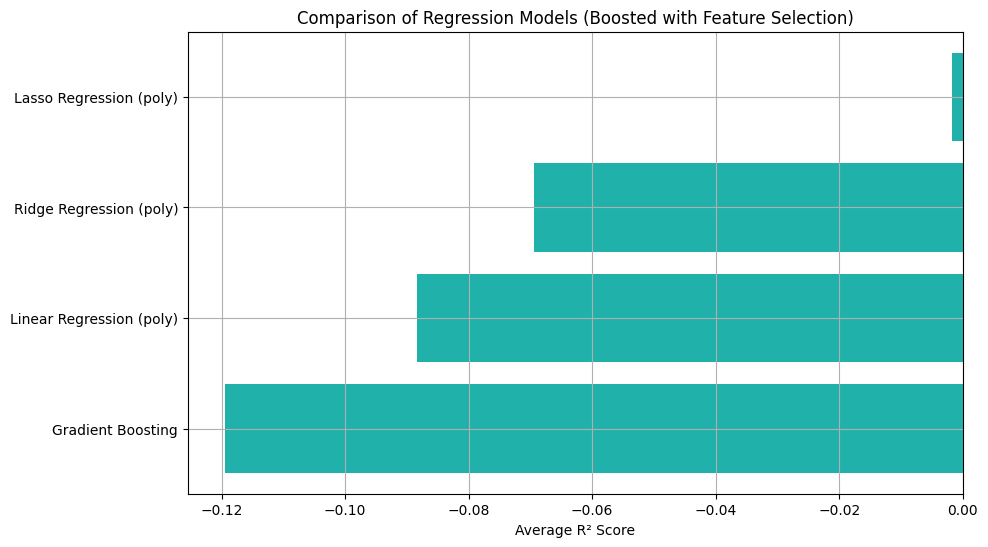

In [26]:
PolynomialModel(data)